In [1]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib as mlt
import scipy
import cv2
import PIL as pil
from scipy import ndimage

In [ ]:
## THE HAAR FILTERS
face_detector=cv2.CascadeClassifier('haar/haarcascade_frontalface_alt.xml')
eye_detector=cv2.CascadeClassifier('haar/haarcascade_eye.xml')
eye_eyeglass = cv2.CascadeClassifier('haar/haarcascade_eye_tree_eyeglasses.xml')
smile_detector=cv2.CascadeClassifier('haar/haarcascade_smile.xml')
nose_detector=cv2.CascadeClassifier('haar/nose.xml')

In [2]:
## THE MEME ASSET POOL
thug = imageio.imread('images/memes/glas.png')
troll = imageio.imread('images/memes/troll.png')
hatter = imageio.imread('images/memes/lucky.png')
jordan = imageio.imread('images/memes/jordan.png')
laserim = imageio.imread('images/memes/laser.png')
moustache = imageio.imread('images/memes/mous.png')
soyjack = imageio.imread('images/memes/soyjack2.png')

In [3]:
#                 FILTER DEFINITIONS

#              (I) ONLY DEEP-FRYING FILTERS  (aka , the filters used for the deep frying process)
#             (II) IMAGE BLENDING AND PASTING FILTER
#            (III) FACE , EYES & NOSE DETECTION FILTERS WITH PASTING   (using haar cascades)
#             (IV) COWBOY FUN FILTER (aka , adding a cowboy hat on image)
#              (V) SEPIA FILTER & COLOR-BRIGHTNESS AND MORE FILTERS
#             (VI) VHS FILTER I&II  (using edge enhancement)
#            (VII) PSEUDO-COLOURED IMAGE
#           (VIII) WHERE IS WALDO (aka pasting the face to a soyjack pic)

In [4]:
###                                       (I)

In [5]:
# SHARPENESS FILTER
def sharp_filter(image,iterations):
    kernel = np.array([[0,-1,0] , [-1,5,-1] , [0,-1,0]])   # The standard sharpening kernel
    
    
    helphand = np.array(image , copy=True).astype(np.uint8)  # Create a copy of an image
    
    sharp = np.zeros_like(helphand)
    sharp = cv2.filter2D(helphand,-1, kernel)
    
    for i in range(iterations):                  # Here I will keep the iterations at 1 , because after 3 iters the image's context gets "destroyed" , but if anyone wants can change it 
        sharp = cv2.filter2D(sharp,-1, kernel)
    
    return sharp.astype(np.uint32)

In [6]:
# SATURATION FILTER

def saturation_filter(image, saturation):
    helphand = np.array(image , copy=True).astype(np.uint8)        # Create a copy of an image
    hsv_image = mlt.colors.rgb_to_hsv(image)                    # Transform the image to the HSV-plain  (At first glance I thought this would be easier) . It isnt the most accurate but a good aproxximation
    
    hsv_image[:,:,1] = np.clip(hsv_image[:,:,1]*saturation,0,255)    # Here if im correct the 'saturation' variable is %
     
    rgb_im = mlt.colors.hsv_to_rgb(hsv_image)
    
    return np.clip(rgb_im,0,255).astype(np.uint8)

In [7]:
# HUE FILTER

def hue_filter(image, ha):
    helphand = np.array(image , copy=True).astype(np.uint32)   # Here we do the same acts as above
    hsv_image = mlt.colors.rgb_to_hsv(image)
    
    hsv_image[:,:,0] = np.clip(hsv_image[:,:,0]-ha,0,255)
     
    rgb_im = mlt.colors.hsv_to_rgb(hsv_image)
    
    return np.clip(rgb_im,0,255).astype(np.uint8)

In [8]:
# BRIGHTNESS FILTER

def brightness_filter(image):
    helphand = np.array(image , copy=True).astype(np.uint32)
    hsv_image = mlt.colors.rgb_to_hsv(helphand)
    
    hsv_image[:,:,2] = np.clip(hsv_image[:,:,2]+20,0,255)
     
    rgb_im = mlt.colors.hsv_to_rgb(hsv_image)
    
    return np.clip(rgb_im,0,255).astype(np.uint8)

In [9]:
# CONTRUST FILTER  (USING THE LOGISTICS EQUATION)

def contrust(proc_im , k = 0.035):
    return(255/(1+np.exp(-k*(proc_im.astype(np.int32) - 127)))).astype(np.uint8)

In [10]:
# GAUSSIAN BLUR FILTER

def gaussian_blur(image):
    gkernel = (1/16)*np.array([[1,2,1] , [2,4,2] , [1,2,1]])   # Create the 3x3 Gaussian kernel
    
    
    helphand = np.array(image , copy=True).astype(np.uint8)
    
    bulr = np.zeros_like(helphand)
    bulr = cv2.filter2D(helphand,-1, gkernel)    # Convolution time
    
    return bulr.astype(np.uint32)

In [11]:
# MOSAIC FILTER  (DONT ASK ME WHY I NAMED IT LIKED THAT , IT RESSEMBLED A MOSAIC THE FIRST TIME)

def mosaic(image):
    step1= np.array(image , copy=True).astype(np.uint32)    # Creating a copy of the image
    
    # NOthing special here , just stacking filters atop of each other
    step3 = sharp_filter(step1,1)
    step2 = gaussian_blur(step3)
    step4 = saturation_filter(step2,1)
    step5 = hue_filter(step4,30)
    
    return step5

In [12]:
###                                       (II)

In [13]:
# PASTING OR ADDING IMAGES FILTER

def asset_adder(back, front, x,y):
    # converting image to rgba
    
    if back.shape[2] == 3:
        back = cv2.cvtColor(back, cv2.COLOR_BGR2BGRA)
    if front.shape[2] == 3:
        front = cv2.cvtColor(front, cv2.COLOR_BGR2BGRA)

    # cropping the overlay from both images
    
    bh,bw = back.shape[:2]             # taking thw width and height of both images , here note: front -> meme , back -> image
    fh,fw = front.shape[:2]
    
    x1, x2 = max(x, 0), min(x+fw, bw)    # two secret ingredients for initalization
    y1, y2 = max(y, 0), min(y+fh, bh)
    
    front_cropped = front[y1-y:y2-y, x1-x:x2-x]    # "Copying" the part of the asset that we want to use
    back_cropped = back[y1:y2, x1:x2]

    alpha_front = front_cropped[:,:,3:4] / 255     # Making alpha as low as possible (Lets say its the MAX transparency we can achieve)
    alpha_back = back_cropped[:,:,3:4] / 255
    
    # replacing the area in result with overlay
    
    result = back.copy()
    result[y1:y2, x1:x2, :3] = alpha_front * front_cropped[:,:,:3] + (1-alpha_front) * back_cropped[:,:,:3]  # this part isnt mine , and sadly I cannot find the source to display it
    result[y1:y2, x1:x2, 3:4] = (alpha_front + alpha_back) / (1 + alpha_front*alpha_back) * 255
    
    result = cv2.cvtColor(result,cv2.COLOR_BGRA2BGR)
    

    return result

In [14]:
###                                       (III)



###   Every filter in this category follows the firsts filters principles

In [15]:
# LASER EYES FILTER

def laser_filt(image,asset):
    imgback = np.array(image , copy=True).astype(np.uint8)  # creating a copy of the image
    gray_img = cv2.cvtColor(imgback, cv2.COLOR_BGR2GRAY)   # Grayscale image
    assetback = np.array(asset , copy=True).astype(np.uint8) # creating a copy of the asset
    
    
    
    face_results = face_detector.detectMultiScale(gray_img, 1.3,5)  # go on and find the face (It's coordinates)
    
    
    
    for (x,y,w,h) in face_results:
        roi_gray = gray_img[y:y+h, x:x+w]          # Creating a grayscale image in the face area
        roi_color = imgback[y:y+h, x:x+w]          # Creating a copy of the face area image
    
        eyes = eye_eyeglass.detectMultiScale(roi_gray)    # Get the eye Coordinates
    
    
        for (ex,ey,ew,eh) in eyes:
            
            laser_res = cv2.resize(assetback, (ew, eh),  interpolation=cv2.INTER_AREA)  # Resizing the asset image to the widht , height of the detected aeyes area
 
            imgback = asset_adder(imgback,laser_res,x+ex,y+ey)  # Paste the resized asset image on the eyes area
    
    
    return imgback

In [16]:
###                                  !!!!!**!!!!!

# I had to add that filter right here due to running errors  (I) part

In [17]:
# DEEP-FRYING  FILTER

def deep_fryer(image,meme):            # Nothing special and here. We just pass the image through all the filters
    point2 = laser_filt(image,meme)
    point3 = laser_filt(point2,meme)
    point3 = laser_filt(point3,meme)
    point3 = contrust(point3)
    point4 = mosaic(point3)
    for i in range(2):
        point4 = brightness_filter(point4)
        point5 = mosaic(point4)
    
    point5 = mosaic(contrust(point5))
    
    return point5.astype(np.uint32)

In [18]:
###                                  !!!!!**!!!!!

In [19]:
# FACE FILTER

def face_filt(image,asset):        
    imgback = np.array(image , copy=True).astype(np.uint8)  # creating a copy of the image
    gray_img = cv2.cvtColor(imgback, cv2.COLOR_BGR2GRAY)
    assetback =  np.array(asset , copy=True).astype(np.uint8)
    
    
    face_results = face_detector.detectMultiScale(gray_img, 1.3,5) 
    
    for (x, y, w, h) in face_results:
        res = cv2.resize(assetback, (w+100,h+100),  interpolation=cv2.INTER_AREA)
    
        fin = asset_adder(imgback,res,x-50,y-50)
    
    return fin

In [20]:
# MOUSTACHE FILTER

def mon_cheri(image,asset):
    imgback = np.array(image , copy=True).astype(np.uint8)  # creating a copy of the image
    gray_img = cv2.cvtColor(imgback, cv2.COLOR_BGR2GRAY)
    assetback = np.array(asset , copy=True).astype(np.uint8)
   
    
    
    face_results = face_detector.detectMultiScale(gray_img, 1.3,5)  
    x,y,w,h = face_results[0]
    
    nose = nose_detector.detectMultiScale(gray_img)
    nx,ny,nw,nh = nose[0]
    
    #for (ex,ey,ew,eh) in eyes:
            
    res = cv2.resize(assetback, (nx, ny),  interpolation=cv2.INTER_AREA)

    imgback = asset_adder(imgback,res,nx,ny+nh)  
    
    
    return imgback

In [21]:
# GLASSES FILTER

def thug_life(image,asset):
    imgback = np.array(image , copy=True).astype(np.uint8)  # creating a copy of the image
    gray_img = cv2.cvtColor(imgback, cv2.COLOR_BGR2GRAY)
    assetback = np.array(asset , copy=True).astype(np.uint8)
   
    
    
    face_results = face_detector.detectMultiScale(gray_img, 1.3,5)  # go on and find the face
    x,y,w,h = face_results[0]
    
    eyes = eye_eyeglass.detectMultiScale(gray_img)
    ex,ey,ew,eh = eyes[0]
    
    #for (ex,ey,ew,eh) in eyes:
            
    res = cv2.resize(assetback, (ex-ew, ey-eh),  interpolation=cv2.INTER_AREA)

    imgback = asset_adder(imgback,res,x,y+eh)  
    
    
    return imgback

In [22]:
###                                       (IV)

In [23]:
# HAT FILTER

def hat_filter(image,asset):
    imgback = np.array(image , copy=True).astype(np.uint8)  # creating a copy of the image
    gray_img = cv2.cvtColor(imgback, cv2.COLOR_BGR2GRAY)
    assetback =  np.array(asset , copy=True).astype(np.uint8)
    
    
    face_results = face_detector.detectMultiScale(gray_img, 1.3,5)  # go on and find the face
    
    for (x, y, w, h) in face_results:
        res = cv2.resize(assetback, (y+w,y+h),  interpolation=cv2.INTER_AREA)
    
        fin = asset_adder(imgback,res,x-w//2+x//2,y-h//2-y//4)
    
    return fin
  

In [24]:
###                                       (V)

In [25]:
# SEPIA FILTER

def sepia_filter(image):
    img_sepia = np.array(image , copy=True).astype(np.uint32)  # creating a copy of the image
    
    # the only intersting here is that we play with the colour palette to give our image that yellowish tone
    img_sepia[:,:,0] = np.clip(0.393*image[:,:,0].astype(np.uint32) + 0.769*image[:,:,1].astype(np.uint32)+ 0.189*image[:,:,2].astype(np.uint32),0,255)
    img_sepia[:,:,1] = np.clip(0.349*image[:,:,0].astype(np.uint32) + 0.686*image[:,:,1].astype(np.uint32)+ 0.168*image[:,:,2].astype(np.uint32),0,255)
    img_sepia[:,:,2] = np.clip(0.272*image[:,:,0].astype(np.uint32) + 0.534*image[:,:,1].astype(np.uint32)+ 0.131*image[:,:,2].astype(np.uint32),0,255)
    
    return img_sepia

In [26]:
###                                       (VI)

In [27]:
# NOISE FILTER (GAUSSIAN NOISE)

def nois(image):
    joy = np.array(image, copy=True).astype(np.uint8) 
    mean = 60
    stddev = 28
    noise = np.zeros(joy.shape, np.uint8)
    cv2.randn(noise, mean, stddev)   # Filling the array with random numbers

    # Add noise to image
    noisy_img = joy+noise
    
    
    return noisy_img

In [28]:
# VHS ALIKE FILTER I (Naive approach , not using grayscale images)

def vhs_filter(image):
    imageback = np.array(image , copy=True).astype(np.uint8)
    
    edge = ndimage.gaussian_laplace(imageback,2)         # Here we apply the gaussian laplacian edge detection algorith , or better an altered version of it. It will still produce some kind of edges, but it will retain some colour
    
    shifter = ndimage.shift(edge,(0,np.floor(edge.shape[0]/50),0),mode='nearest')    # Shifting the image to the left
    
    pre_end = nois(imageback)   
    
    fin = shifter|pre_end      # Here with some pixel manipulation we avoid the "harsh" way of implementing it , meanning that we had to corrupt the original 'analog' signal
                               # What is achieved is a pseudo-Vhs experience
    return fin

In [29]:
# Here I shall include all the shifting functions for vhs2

def shifter_r(image):
    
    fin = ndimage.shift(image,(0,np.floor(image.shape[0]/50)),mode='nearest')
    
    return fin


def shifter_b(image):
    
    fin = ndimage.shift(image,(0,np.floor(image.shape[0]/20)),mode='nearest')
    
    return fin



def shifter_g(image):
    
    fin = ndimage.shift(image,(0,np.floor(image.shape[0]/30)),mode='nearest')
    
    return fin

In [30]:
# Colour changing( THe truth is that the only colours that we change is black :^(.T                     )

def red_colouring(image):  # We say image but in reality we shall use only the edges 
    reddish_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    reddish_image[np.where((reddish_image==[0,0,0]).all(axis=2))] = [255,10,255]  # here actually this is closer to pink than red
# Here we ask where are the pixels with value[0,0,0] ---> Black pixels and we tell them to colour there selfs to the value [255,10,255] -----> pink
    
    
    return reddish_image

#repeat the procedure for the other 2 colours

def blue_colouring(image):  
    blueish_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    blueish_image[np.where((blueish_image==[0,0,0]).all(axis=2))] = [0,190,255]
    
    return blueish_image



def green_colouring(image):  
    greenish_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    greenish_image[np.where((greenish_image==[0,0,0]).all(axis=2))] = [10,255,10]
    
    return greenish_image


In [31]:
# VHS ALIKE FILTER II (Now our gray images are the image channels and we shall try to somehow sandwich them together)

def vhs_filter2(image):
    if image.shape[2] == 4:
        time = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    else:
        time = image
    
    
    imageback = np.array(time , copy=True).astype(np.uint8)
    
    red_one = imageback[:,:,0]
    blue_one = imageback[:,:,1]
    green_one = imageback[:,:,2]
    
    red_blur = ndimage.gaussian_filter(red_one,0.5)  #Bluring using the ndimage cause my gaussian blur overloads
    red_edge = cv2.adaptiveThreshold(red_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 1.5) # Edges with Threshold
   
    #repeat another 2 times

    blue_blur = ndimage.gaussian_filter(blue_one , 1)
    blue_edge = cv2.adaptiveThreshold(blue_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,3 ,2) 
    
    green_blur = ndimage.gaussian_filter(green_one , 1)
    green_edge = cv2.adaptiveThreshold(green_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,3 ,2)
    
    
    # Now time to shift our images , remember the images are still grayscale
    
    red_shift = shifter_r(red_edge)
    blue_shift = shifter_b(blue_edge)
    green_shift = shifter_g(green_edge)

    # Now colourpaint the images(the transformation happens inside the i-colouring , i = red,blur,green)
    
    red_c_edge = red_colouring(red_shift)  # Making the black-colour edges of the red channel red (in reality pink)
    blue_c_edge = blue_colouring(blue_shift)  # Making the black-colour edges of the blue channel blue (light blue actually)
    green_c_edge = green_colouring(green_shift) # The same applies here
    
    final_image = imageback&red_c_edge&blue_c_edge&green_c_edge   # Applying each image atop the other (What & does it retains each colour-image colour meaning pink , blue , etc whilst also retaining the base image(DOESNT CHANGE IT)) 
    
    
    return final_image
    

In [32]:
###                                       (VII)

In [33]:
# PSEUDO-COLOURING FILTER

def pseudo_color(image,gray_image):
    imgback = np.array(image , copy=True).astype(np.uint8) # creating a copy of the image
    blur34 = np.array(gray_image , copy=True).astype(np.uint8)
    gray_img = cv2.cvtColor(imgback, cv2.COLOR_BGR2GRAY)
    
    face_results = face_detector.detectMultiScale(gray_img, 1.3,5)
    
    for(x,y,w,h) in  face_results:
        img2 = imgback[y:y + h+h//2, x:x + w]        # Saving the face that we detected in the image

    
    fin = asset_adder(cv2.cvtColor(blur34,cv2.COLOR_BGR2RGBA),img2,x,y)   # Now with some manipulation Paste the coloured face in its position on the "grayscale" image(of course the image is not grayscale, but we consider it as)
    
    return fin
    

In [34]:
###                                       (VIII)

In [35]:
# FACE PASTING FILTER

def face_paster(image):
    imgback = np.array(image , copy=True).astype(np.uint8)
    gray_img = cv2.cvtColor(imgback, cv2.COLOR_BGR2GRAY)
    assetback = np.array(soyjack , copy=True).astype(np.uint8)
    
    face_results = face_detector.detectMultiScale(gray_img, 1.3,5)
    
    x,y,w,h = face_results[0]
    
    face_img = imgback[y:y+h, x:x+w]   # Here we create a new image containing only the face
    
    res_face = cv2.resize(face_img,(150,150), interpolation=cv2.INTER_LINEAR) # the face image resized to 150x150 pixels
    
    proc_img = asset_adder(assetback,res_face,320,50)  # paste the resized face image to the second soyjack's face (whose pixels are fixed , so we dont need to detect its face)
    
    return proc_img

In [36]:
#

In [37]:
#

In [38]:
#

Please declare the path of the image , in order to be processed (including the image type): images/limerick-ireland.jpg
Image accepted bro with da correct format being:  JPEG


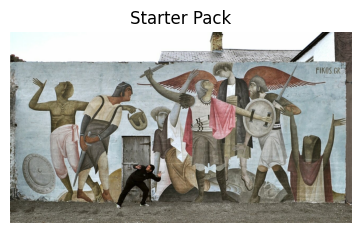


I think its time we create something something

THE CHOISES GIVEN TO YOU ARE THESE:
(I)Press a for some deep-frying
(II)Press b for cowboy fun
(III)Press c for some classic thug life experience
(IV)Press d for some simlpe laser eyes
(V)Press e for the claasic trollface to appear on your image
(VI)Press f for sad Jordan to become happy
(VII)Press g to teleport to France(Not recommended by author)
(VIII)Press s to apply THE sepia filter
(IX)Press p for some pesudo-colouring filter
(X)Press v for some classic antiquity vhs style
(XI)Press u for some classic more original  antiquity vhs style
(XII)Press j to paste the image's face to a soyjack meme
(XII)Or press q to quit the programm: 
v


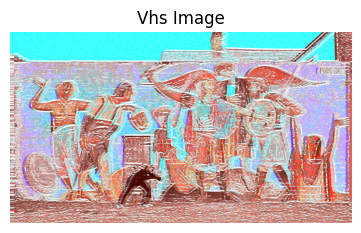

If you are happy with the meme press y to terminate the process and save your meme
Or press z to choose another alternative
: z
Okay returningback
THE CHOISES GIVEN TO YOU ARE THESE:
(I)Press a for some deep-frying
(II)Press b for cowboy fun
(III)Press c for some classic thug life experience
(IV)Press d for some simlpe laser eyes
(V)Press e for the claasic trollface to appear on your image
(VI)Press f for sad Jordan to become happy
(VII)Press g to teleport to France(Not recommended by author)
(VIII)Press s to apply THE sepia filter
(IX)Press p for some pesudo-colouring filter
(X)Press v for some classic antiquity vhs style
(XI)Press u for some classic more original  antiquity vhs style
(XII)Press j to paste the image's face to a soyjack meme
(XII)Or press q to quit the programm: 
u


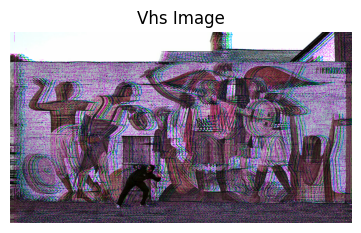

If you are happy with the meme press y to terminate the process and save your meme
Or press z to choose another alternative
: z
Okay returningback
THE CHOISES GIVEN TO YOU ARE THESE:
(I)Press a for some deep-frying
(II)Press b for cowboy fun
(III)Press c for some classic thug life experience
(IV)Press d for some simlpe laser eyes
(V)Press e for the claasic trollface to appear on your image
(VI)Press f for sad Jordan to become happy
(VII)Press g to teleport to France(Not recommended by author)
(VIII)Press s to apply THE sepia filter
(IX)Press p for some pesudo-colouring filter
(X)Press v for some classic antiquity vhs style
(XI)Press u for some classic more original  antiquity vhs style
(XII)Press j to paste the image's face to a soyjack meme
(XII)Or press q to quit the programm: 
q


In [42]:
flag = 1

path_to_img = input("Please declare the path of the image , in order to be processed (including the image type): ") #Read the image input path and save it as a char string


typr = pil.Image.open(path_to_img)  # This isnt optimal , but it saves a lot of time. Here we read the image 2 times:
# at first we read it as an PIL tyoe of image in order to get the images type. Then if its on the acceptable type range , we proceed to "read" it as an numpy array in order to manipulate it later


while flag == 1 :
    if (typr.format == 'JPEG') | (typr.format == 'PNG') | (typr.format == 'TIFF') :
        print('Image accepted bro with da correct format being: ' , typr.format)
        
        img = imageio.imread(path_to_img)
        
        flag = 0 
    else :
        print('Wrong Image type bro , try again')
        flag =1 
        
        
plt.figure(figsize =(15,10))
plt.subplot(131); plt.axis('off') ;plt.imshow(img) ; plt.title("Starter Pack")
plt.show()

print('\nI think its time we create something something\n')

flag = 1

while flag == 1 :
    sauce_ingr = input("THE CHOISES GIVEN TO YOU ARE THESE:\n(I)Press a for some deep-frying\n(II)Press b for cowboy fun\n(III)Press c for some classic thug life experience\n(IV)Press d for some simlpe laser eyes\n(V)Press e for the claasic trollface to appear on your image\n(VI)Press f for sad Jordan to become happy\n(VII)Press g to teleport to France(Not recommended by author)\n(VIII)Press s to apply THE sepia filter\n(IX)Press p for some pesudo-colouring filter\n(X)Press v for some classic antiquity vhs style\n(XI)Press u for some classic more original  antiquity vhs style\n(XII)Press j to paste the image's face to a soyjack meme\n(XII)Or press q to quit the programm: \n")
    
    
    if sauce_ingr == 'a':
        fin_img = deep_fryer(img,laserim)
        
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Deep-Fryed Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
    
    elif sauce_ingr == 'b':
        fin_img = hat_filter(img,hatter)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Cowboy Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
            
    elif sauce_ingr == 'c':
        fin_img = thug_life(img,thug)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Thug Life Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
    
    elif sauce_ingr == 'd':
        fin_img = laser_filt(img,laserim)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Lasers Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
    
    elif sauce_ingr == 'e':
        fin_img = face_filt(img,troll)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Troll-face Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
            
    elif sauce_ingr == 'f':
        fin_img = face_filt(img,jordan)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Jordan Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
    
    elif sauce_ingr == 'g':
        fin_img = mon_cheri(img,moustache)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Frenchie Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
    
    elif sauce_ingr == 's':
        fin_img = sepia_filter(img)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Sepia Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
            
    elif sauce_ingr == 'v':
        fin_img = vhs_filter(img)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Vhs Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
    
    elif sauce_ingr == 'u':
        fin_img = vhs_filter2(img)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Vhs Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
    
    elif sauce_ingr == 'p':
        fin_img = pseudo_color(img,gaussian_blur(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)))
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Pseudo-Coloured Image")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
    
    elif sauce_ingr == 'j':
        fin_img = face_paster(img)
         
        plt.figure(figsize =(15,10))
        plt.subplot(131); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Soyjack Meme")
        plt.show()
        
        finito = input("If you are happy with the meme press y to terminate the process and save your meme\nOr press z to choose another alternative\n: ")
        
        if finito == 'y':
            plt.figure(figsize =(15,10))
            plt.subplot(); plt.axis('off') ;plt.imshow(fin_img) ; plt.title("Meme2Be Saved")
            plt.savefig('meme.jpeg')
            flag = 0
        else :
            print ('Okay returningback')
            flag = 1
            
    else:
        flag = 0